In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline

In [2]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-extra.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()

,azim,azimStd,delMLT,goodFit,MLAT,normMLT,vSaps,velSTD,endPtMLAT,endPtNormMLT,...,dst_index,dst_bin,datetimeStr,AE,AL,AO,AU,count,maxCount,probOcc
0,-88.721973,3.056854,1.0,True,56.5,0.0,439.581783,42.430720,56.51,-0.44,...,-67.0,"(-75, -50]",20131002-08-26,552,-285,-9,267,20,133,0.150376
1,-88.721973,3.056854,1.0,True,56.5,0.0,439.581783,42.430720,56.51,-0.44,...,-72.0,"(-75, -50]",20131002-08-26,552,-285,-9,267,20,133,0.150376
2,-76.286322,NaN,NaN,False,56.5,0.0,782.837900,NaN,56.69,-0.76,...,-53.0,"(-75, -50]",20130525-06-54,401,-155,46,246,20,133,0.150376
3,-76.286322,NaN,NaN,False,56.5,0.0,782.837900,NaN,56.69,-0.76,...,-58.0,"(-75, -50]",20130525-06-54,401,-155,46,246,20,133,0.150376
4,-101.651055,4.944216,1.0,True,56.5,0.0,501.724761,24.297278,56.40,-0.49,...,-53.0,"(-75, -50]",20130525-06-56,389,-162,33,227,20,133,0.150376


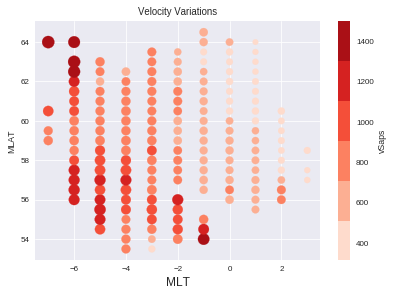

In [3]:
# We'll now divide data into MLT/MLAT bins and get some stats
mltMlatMeanDF = velsDataDF.groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=mltMlatMeanDF["vSaps"]/10, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanVelMLATMLT.pdf",bbox_inches='tight')

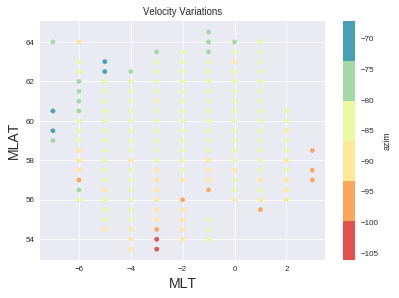

In [4]:
mltMlatMeanDF = velsDataDF[ velsDataDF["goodFit"] ].groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Spectral"))

# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=20, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT", fontsize=14)
ax.set_xlabel("MLT", fontsize=14)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanAzimMLATMLT.pdf",bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


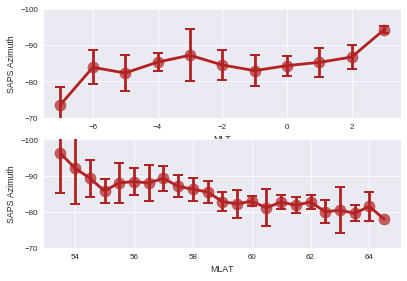

In [5]:
# Plot Mean and Std of Azims vs MLT and MLAT!
azimMLTMeanDF = mltMlatMeanDF[[ "normMLT", "azim" ]].groupby( [ "normMLT" ] ).mean().reset_index()
azimMLTMeanDF.columns = [ "normMLT", "azim_est_mlt_mean" ]
azimMLTStdDF = mltMlatMeanDF[[ "normMLT", "azim" ]].groupby( [ "normMLT" ] ).std().reset_index()
azimMLTStdDF.columns = [ "normMLT", "azim_est_mlt_std" ]
azimMLTMeanDF = pandas.merge( azimMLTMeanDF, azimMLTStdDF, on=[ "normMLT" ] )
# GET MLAT MEAN/STD
azimMLATMeanDF = mltMlatMeanDF[[ "MLAT", "azim" ]].groupby( [ "MLAT" ] ).mean().reset_index()
azimMLATMeanDF.columns = [ "MLAT", "azim_est_mlat_mean" ]
azimMLATStdDF = mltMlatMeanDF[[ "MLAT", "azim" ]].groupby( [ "MLAT" ] ).std().reset_index()
azimMLATStdDF.columns = [ "MLAT", "azim_est_mlat_std" ]
azimMLATMeanDF = pandas.merge( azimMLATMeanDF, azimMLATStdDF, on=[ "MLAT" ] )
# setup fig
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# seaborn styling
sns.set_style("whitegrid")
sns.set_context("poster")

azimMLTMeanDF = azimMLTMeanDF.sort(["normMLT"])
ax1.scatter(azimMLTMeanDF['normMLT'],
            azimMLTMeanDF['azim_est_mlt_mean'],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124)
ax1.errorbar(azimMLTMeanDF['normMLT'],\
             azimMLTMeanDF['azim_est_mlt_mean'],\
             yerr=azimMLTMeanDF['azim_est_mlt_std'], \
             color='firebrick', label='', capthick=2., capsize=5.)

# PLOT MLAT MEAN STDs
ax2.scatter(azimMLATMeanDF['MLAT'],
            azimMLATMeanDF['azim_est_mlat_mean'],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124)
ax2.errorbar(azimMLATMeanDF['MLAT'],\
             azimMLATMeanDF['azim_est_mlat_mean'],\
             yerr=azimMLATMeanDF['azim_est_mlat_std'], \
             color='firebrick', label='', capthick=2., capsize=5.)
# plt.rcParams['axes.labelweight'] = 'bold'
ax1.set_ylim( [-70,-100] )
ax2.set_ylim( [-70,-100] )
ax1.set_xlabel("MLT")
ax2.set_xlabel("MLAT")
ax1.set_ylabel("SAPS Azimuth")
ax2.set_ylabel("SAPS Azimuth")
plt.savefig("../figs/meanStdAzim.pdf",bbox_inches='tight')

In [6]:
# Groupby Dst bin
dstLocDF = velsDataDF.groupby( [ "dst_bin", "normMLT", "MLAT" ] ).mean().reset_index()
dstLocDF.head()

,dst_bin,normMLT,MLAT,azim,azimStd,delMLT,goodFit,vSaps,velSTD,endPtMLAT,...,hour,minute,dst_index,AE,AL,AO,AU,count,maxCount,probOcc
0,"(-10, 10]",-3.0,62.0,-81.561156,2.317198,1.352941,0.485714,930.856868,50.221843,62.131429,...,6.971429,33.657143,-4.685714,359.942857,-215.000000,-35.085714,144.942857,35.0,196.0,0.178571
1,"(-10, 10]",-3.0,62.5,-80.332990,2.008963,1.272727,0.343750,910.062259,51.064544,62.640000,...,6.781250,31.843750,-5.156250,372.859375,-252.828125,-66.562500,120.031250,64.0,196.0,0.326531
2,"(-10, 10]",-3.0,63.0,-80.457366,2.118258,1.272727,0.360656,856.761403,39.141036,63.130164,...,7.459016,25.934426,-3.360656,282.459016,-173.540984,-32.540984,108.918033,61.0,196.0,0.311224
3,"(-10, 10]",-3.0,63.5,-78.311037,1.714904,1.250000,0.761905,763.424449,46.455551,63.652381,...,5.761905,25.047619,-4.000000,198.666667,-139.761905,-40.761905,58.904762,42.0,196.0,0.214286
4,"(-10, 10]",-2.0,60.5,-78.134891,3.334471,1.300000,0.714286,602.408504,52.656229,60.634286,...,6.738095,18.952381,-6.904762,405.404762,-265.571429,-63.023810,139.833333,42.0,196.0,0.214286


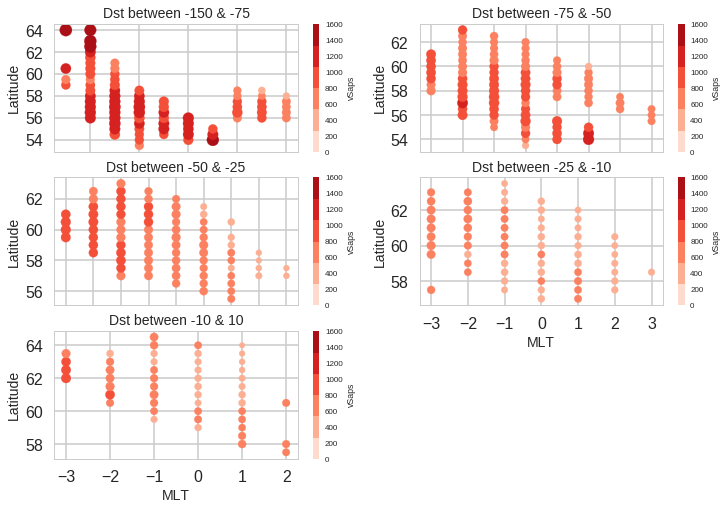

In [7]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

velMax = 1600.
velMin = 0.

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (-150,-75]
dstSapsMLTLat15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]
dstSapsMLTLat15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat15075["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax1, sharex=True)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )
# (-75, -50]
dstSapsMLTLat7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]
dstSapsMLTLat7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat7550["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )
# (-50, -25]
dstSapsMLTLat5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]
dstSapsMLTLat5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat5025["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )
# (-25, -10]
dstSapsMLTLat2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]
dstSapsMLTLat2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat2510["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )
# (-10, 10]
dstSapsMLTLat1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]
dstSapsMLTLat1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat1010["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax5)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVels.pdf",bbox_inches='tight')

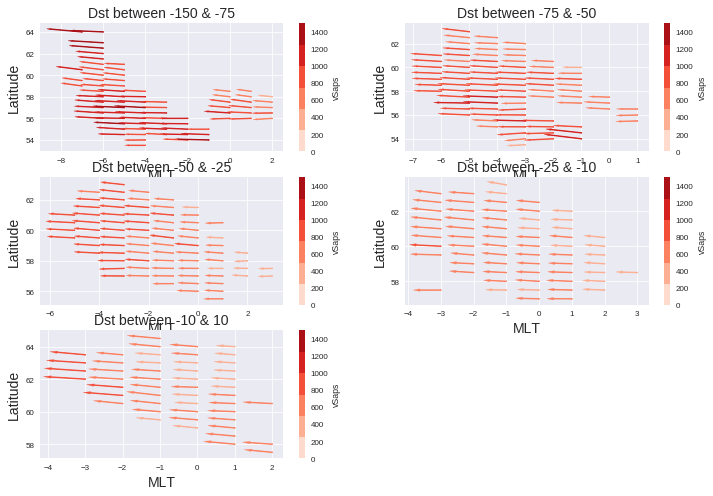

In [8]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

# Now setup a velocity scale
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (dstLocDF["vSaps"].max() + 100.)*100/100\
    - (dstLocDF["vSaps"].max() + 100.)%100

# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

fitResultsDF15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]     
fitResultsDF15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax1)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )

plotMLTends = fitResultsDF15075['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF15075['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF15075['normMLT'].tolist()
plotMLATbegins = fitResultsDF15075['MLAT'].tolist()
plotVelMagns = fitResultsDF15075['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax1.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax1.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
        

fitResultsDF7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]     
fitResultsDF7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax2)

plotMLTends = fitResultsDF7550['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF7550['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF7550['normMLT'].tolist()
plotMLATbegins = fitResultsDF7550['MLAT'].tolist()
plotVelMagns = fitResultsDF7550['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax2.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax2.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )


fitResultsDF5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]     
fitResultsDF5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax3)

plotMLTends = fitResultsDF5025['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF5025['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF5025['normMLT'].tolist()
plotMLATbegins = fitResultsDF5025['MLAT'].tolist()
plotVelMagns = fitResultsDF5025['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax3.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax3.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )


        
        
fitResultsDF2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]     
fitResultsDF2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax4)

plotMLTends = fitResultsDF2510['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF2510['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF2510['normMLT'].tolist()
plotMLATbegins = fitResultsDF2510['MLAT'].tolist()
plotVelMagns = fitResultsDF2510['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax4.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax4.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        

ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )        
        
        
fitResultsDF1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]     
fitResultsDF1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax5)

plotMLTends = fitResultsDF1010['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF1010['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF1010['normMLT'].tolist()
plotMLATbegins = fitResultsDF1010['MLAT'].tolist()
plotVelMagns = fitResultsDF1010['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax5.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax5.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVelVecs.pdf",bbox_inches='tight')

In [9]:
# Not only velocity magnitudes we'd also 
# like to plot azimuths!
# get the end points of vectors
dstLocDF["plot_MLATEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["MLAT"], 2)
dstLocDF["plot_normMLTEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["normMLT"], 2)
# Store the data in a file to be used with IDL
# Calculate the median dst in each dst bin
dstBinMedians = velsDataDF.groupby(["dst_bin"]).median().reset_index()
dstBinMedians = dstBinMedians[ [ "dst_bin", "dst_index" ] ]
dstBinMedians.columns = [ "dst_bin", "dst_median" ]
dstBinMedians.head()
sapsVelstoCsv = dstLocDF[ [ "dst_bin", "normMLT", "MLAT",\
                            "vSaps", "azim", "plot_MLATEnd", "plot_normMLTEnd" ] ]
sapsVelstoCsv = pandas.merge( sapsVelstoCsv, dstBinMedians, on=["dst_bin"] )
sapsVelstoCsv["vSaps"] = sapsVelstoCsv["vSaps"].map( lambda x: round(x,2) )
sapsVelstoCsv["azim"] = sapsVelstoCsv["azim"].map( lambda x: round(x,2) )
sapsVelstoCsv = sapsVelstoCsv[ [ "normMLT", "MLAT",\
                            "vSaps", "azim", "plot_MLATEnd", "plot_normMLTEnd", "dst_median" ] ]
sapsVelstoCsv.to_csv("../data/sapsVelsMagnAzimDst.txt", sep=' ', index=False, header=False)

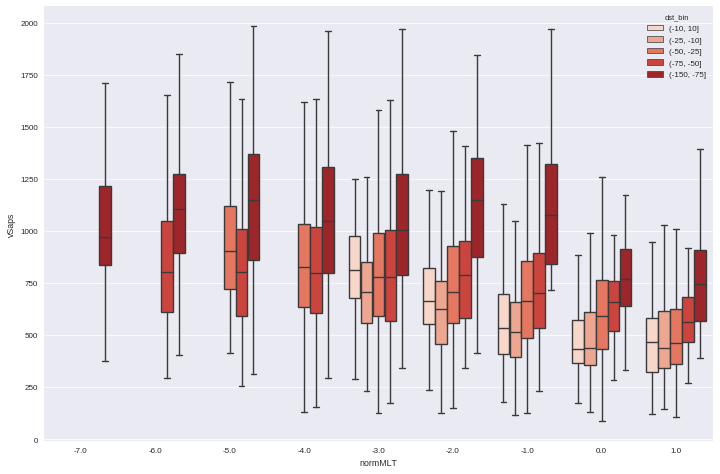

In [10]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
dst_order = [ '(-10, 10]', '(-25, -10]', '(-50, -25]', '(-75, -50]', '(-150, -75]' ]
sns.boxplot( x="normMLT", y="vSaps", hue="dst_bin", data=velsDataDF[ (velsDataDF["normMLT"] < 2.) ],\
            hue_order=dst_order, palette="Reds", showfliers=False )
plt.savefig("../figs/Dst-MLT-Vels.pdf",bbox_inches='tight')

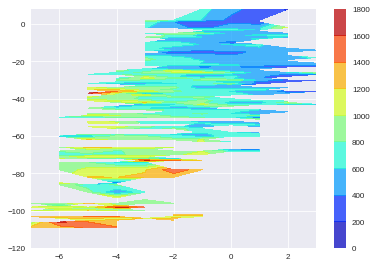

In [35]:
mltDstIndVelDF = velsDataDF[ ["dst_index", "normMLT",\
                    "vSaps"] ].groupby( ["dst_index", "normMLT"]\
                                    ).mean()
velPivot = mltDstIndVelDF.reset_index().pivot( "dst_index", "normMLT" )
X=velPivot.columns.levels[1].values
Y=velPivot.index.values
Z=velPivot.values
Xi,Yi = numpy.meshgrid(X, Y)
plt.contourf(Xi, Yi, Z, alpha=0.7, cmap=plt.cm.jet)
plt.colorbar()

In [45]:
dstbinMed = velsDataDF[ ["dst_bin", "dst_index"] ].groupby( ["dst_bin"]\
                                    ).median().reset_index()
dstbinMed.columns = [ "dst_bin", "dst_median" ]
mltDstBinVelMean = velsDataDF[ ["dst_bin", "normMLT",\
                    "vSaps"] ].groupby( ["dst_bin", "normMLT"]\
                                    ).mean().reset_index()
mltDstBinVelMean.columns = [ "dst_bin", "normMLT", "vel_mean" ]
mltDstBinVelStd = velsDataDF[ ["dst_bin", "normMLT",\
                    "vSaps"] ].groupby( ["dst_bin", "normMLT"]\
                                    ).std().reset_index()
mltDstBinVelStd.columns = [ "dst_bin", "normMLT", "vel_std" ]
mltDstBinVelMean = pandas.merge( mltDstBinVelMean, mltDstBinVelStd,\
                                on=[ "dst_bin", "normMLT" ] )
mltDstBinVelMean = pandas.merge( mltDstBinVelMean, dstbinMed, on=["dst_bin"] )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


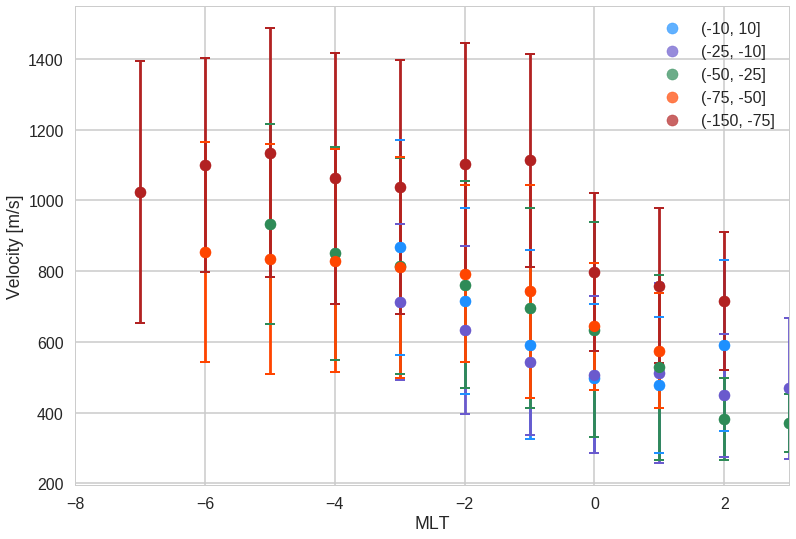

In [51]:
sns.set_style("whitegrid")
sns.set_context("poster")

#mltDstBinVelMean['normMLT'] = [x-24 if x >= 12 else x for x in mltDstBinVelMean['sapsMLT']]
mltDstBinVelMean["vel_std"] = mltDstBinVelMean["vel_std"].fillna(20.)
mltDstBinVelMean = mltDstBinVelMean.sort(["normMLT"])
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######

plt.scatter(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-10, 10]"],
            mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
plt.errorbar(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-10, 10]"],\
             mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-10, 10]"],\
             yerr=mltDstBinVelMean['vel_std'][mltDstBinVelMean['dst_bin'] == "(-10, 10]"], \
             color='dodgerblue', label='', capthick=2., capsize=5., fmt='o')


#plt.xticks(mltDstBinVelMean['normMLT'].unique(), \
#           mltDstBinVelMean['sapsMLT'].unique(), size='small')

###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
plt.scatter(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-25, -10]"],
            mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
plt.errorbar(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-25, -10]"],\
             mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-25, -10]"],\
             yerr=mltDstBinVelMean['vel_std'][mltDstBinVelMean['dst_bin'] == "(-25, -10]"], \
             color='slateblue', label='', capthick=2., capsize=5., fmt='o')


#plt.xticks(mltDstBinVelMean['normMLT'].unique(), \
#           mltDstBinVelMean['sapsMLT'].unique(), size='small')
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######



# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######

plt.scatter(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-50, -25]"],
            mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(-50, -25]')
plt.errorbar(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-50, -25]"],\
             mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-50, -25]"],\
             yerr=mltDstBinVelMean['vel_std'][mltDstBinVelMean['dst_bin'] == "(-50, -25]"], \
             color='seagreen', label='', capthick=2., capsize=5., fmt='o')


#plt.xticks(mltDstBinVelMean['normMLT'].unique(), \
#           mltDstBinVelMean['sapsMLT'].unique(), size='small')
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######



# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-75, -50]"],
            mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(-75, -50]')
plt.errorbar(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-75, -50]"],\
             mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-75, -50]"],\
             yerr=mltDstBinVelMean['vel_std'][mltDstBinVelMean['dst_bin'] == "(-75, -50]"], \
             color='orangered', label='', capthick=2., capsize=5., fmt='o')


#plt.xticks(mltDstBinVelMean['normMLT'].unique(), \
#           mltDstBinVelMean['sapsMLT'].unique(), size='small')

# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######



# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######

plt.scatter(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-150, -75]"],
            mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-150, -75]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(-150, -75]')
plt.errorbar(mltDstBinVelMean['normMLT'][mltDstBinVelMean['dst_bin'] == "(-150, -75]"],\
             mltDstBinVelMean['vel_mean'][mltDstBinVelMean['dst_bin'] == "(-150, -75]"],\
             yerr=mltDstBinVelMean['vel_std'][mltDstBinVelMean['dst_bin'] == "(-150, -75]"], \
             color='firebrick', label='', capthick=2., capsize=5., fmt='o')


#plt.xticks(mltDstBinVelMean['normMLT'].unique(), \
#           mltDstBinVelMean['sapsMLT'].unique(), size='small')

# ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
           
plt.xlim( [-8,3] )
# plt.ylim( [0,1000] )
plt.xlabel("MLT")
plt.ylabel("Velocity [m/s]")
plt.legend()
plt.savefig("../figs/meanVelMLT-std.pdf",bbox_inches='tight')